In [ ]:
%cd /content/drive/MyDrive/Zero_Shot_DeepFake_Image_Classification/ImagebindDeepfakeDetection

/content/drive/MyDrive/Zero_Shot_DeepFake_Image_Classification/ImagebindDeepfakeDetection


In [ ]:
!pip install -r requirements.txt --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 101.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.6/152.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [ ]:
import logging
import torch
import data

from models import imagebind_model
from models.imagebind_model import ModalityType, load_module
from models import lora as LoRA
import os
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


logging.basicConfig(level=logging.INFO, force=True)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [ ]:
lora = False
linear_probing = True
device = "cuda:0" if torch.cuda.is_available() else "cpu"
load_head_post_proc_finetuned = True
batch_size = 32

assert not (linear_probing and lora), \
            "Linear probing is a subset of LoRA training procedure for ImageBind. " \
            "Cannot set both linear_probing=True and lora=True. "

In [ ]:
if lora and not load_head_post_proc_finetuned:
    # Hack: adjust lora_factor to the `max batch size used during training / temperature` to compensate missing norm
    lora_factor = batch_size / 0.07
else:
    # This assumes proper loading of all params but results in shift from original dist in case of LoRA
    lora_factor = 1
# Instantiate model
model = imagebind_model.imagebind_huge(pretrained=True)
if lora:
    model.modality_trunks.update(
        LoRA.apply_lora_modality_trunks(model.modality_trunks, rank=4,
                                        # layer_idxs={ModalityType.TEXT: [0, 1, 2, 3, 4, 5, 6, 7, 8],
                                        #             ModalityType.VISION: [0, 1, 2, 3, 4, 5, 6, 7, 8]},
                                        modality_names=[ModalityType.TEXT, ModalityType.VISION]))

    # Load LoRA params if found
    LoRA.load_lora_modality_trunks(model.modality_trunks,
                                   checkpoint_dir=".checkpoints/lora", postfix="_last")

    if load_head_post_proc_finetuned:
        # Load postprocessors & heads
        load_module(model.modality_postprocessors, module_name="postprocessors",
                    checkpoint_dir=".checkpoints/lora", postfix="_last")
        load_module(model.modality_heads, module_name="heads",
                    checkpoint_dir=".checkpoints/lora", postfix="_last")
elif linear_probing:
    # Load heads
    load_module(model.modality_heads, module_name="heads",
                checkpoint_dir="./.checkpoints/lora", postfix="_last")

model.eval()
model.to(device)

INFO:root:Loaded parameters for module heads from ./.checkpoints/lora.


ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (audio): AudioPreprocessor(
      (cls_token): tensor((1, 1, 768), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10), bias=False)
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=

In [ ]:
# Define a custom Dataset class
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.true_labels = []
        self.transform = transform

        for cls in os.listdir(root_dir):
            if os.path.isdir(root_dir + "/" + cls):
                for img in os.listdir(root_dir + "/" + cls):
                    if img.endswith(".png"):
                        self.image_paths.append(os.path.join(root_dir, cls, img))
                        self.true_labels.append(cls)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.true_labels[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose(
                [
                    transforms.Resize(
                        224, interpolation=transforms.InterpolationMode.BICUBIC
                    ),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=(0.48145466, 0.4578275, 0.40821073),
                        std=(0.26862954, 0.26130258, 0.27577711),
                    ),
                ]
            )

In [ ]:
text_list = ["fake", "real"]

# **CELEB**

Loading Data: 100%|██████████| 63/63 [02:13<00:00,  2.11s/it]


Accuracy:  0.8415


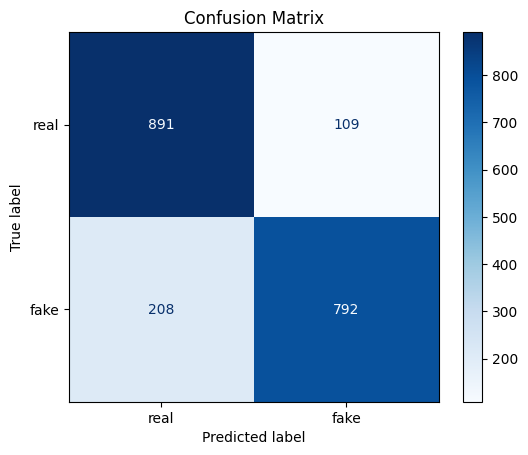

In [ ]:
image_root_path = os.getcwd()+"/dataset/CELEB/test"

# Create dataset and DataLoader
test_dataset = TestDataset(image_root_path, transform=transform)
dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count())

fake_idx = 0
real_idx = 1
pred_labels = []
correct_labels = []
correct = 0
# Iterate through the DataLoader with tqdm to display progress
for images, labels in tqdm(dataloader, total=len(dataloader), desc="Loading Data"):
    inputs = {
        ModalityType.TEXT: data.load_and_transform_text(text_list, device),
        ModalityType.VISION: images.to(device)
    }
    true_labels = labels
    with torch.no_grad():
        embeddings = model(inputs)

    # Assuming that embeddings[ModalityType.TEXT] contains the embedding vectors
    text_embeds = embeddings[ModalityType.TEXT]  # Assuming TEXT embeddings exist
    vision_embeds = embeddings[ModalityType.VISION]

    # Adjust according to whether 'lora' is enabled or not
    lora_factor = lora_factor if lora else 1

    # Softmax over dot product between vision and text embeddings
    similarities = torch.softmax(vision_embeds @ text_embeds.T * lora_factor, dim=-1)

    for i in range(len(true_labels)):
        im_emb = vision_embeds[i]
        true_label = true_labels[i]
        correct_labels.append(true_label)

        # Calculate similarity of current vision embedding with 'fake' and 'real' text embeddings
        sim_fake = similarities[i, fake_idx]  # Assuming `fake_idx` is index for 'fake' in TEXT embeddings
        sim_real = similarities[i, real_idx]  # Assuming `real_idx` is index for 'real' in TEXT embeddings

        # Classification based on the higher similarity score
        if sim_fake > sim_real:
            pred_label = "fake"
        else:
            pred_label = "real"

        pred_labels.append(pred_label)
        if pred_label == true_label:
            correct += 1

print("Accuracy: ", correct/len(pred_labels))
# Create confusion matrix
cm = confusion_matrix(correct_labels, pred_labels, labels=["real", "fake"])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["real", "fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# **CELEB-M**

Loading Data: 100%|██████████| 63/63 [02:17<00:00,  2.18s/it]


Accuracy:  0.682


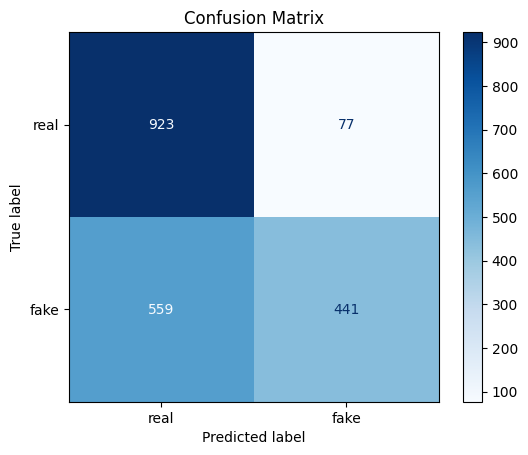

In [ ]:
image_root_path = os.getcwd()+"/dataset/CELEB-M/test"

# Create dataset and DataLoader
test_dataset = TestDataset(image_root_path, transform=transform)
dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count())

fake_idx = 0
real_idx = 1
pred_labels = []
correct_labels = []
correct = 0
# Iterate through the DataLoader with tqdm to display progress
for images, labels in tqdm(dataloader, total=len(dataloader), desc="Loading Data"):
    inputs = {
        ModalityType.TEXT: data.load_and_transform_text(text_list, device),
        ModalityType.VISION: images.to(device)
    }
    true_labels = labels
    with torch.no_grad():
        embeddings = model(inputs)

    # Assuming that embeddings[ModalityType.TEXT] contains the embedding vectors
    text_embeds = embeddings[ModalityType.TEXT]  # Assuming TEXT embeddings exist
    vision_embeds = embeddings[ModalityType.VISION]

    # Adjust according to whether 'lora' is enabled or not
    lora_factor = lora_factor if lora else 1

    # Softmax over dot product between vision and text embeddings
    similarities = torch.softmax(vision_embeds @ text_embeds.T * lora_factor, dim=-1)

    for i in range(len(true_labels)):
        im_emb = vision_embeds[i]
        true_label = true_labels[i]
        correct_labels.append(true_label)

        # Calculate similarity of current vision embedding with 'fake' and 'real' text embeddings
        sim_fake = similarities[i, fake_idx]  # Assuming `fake_idx` is index for 'fake' in TEXT embeddings
        sim_real = similarities[i, real_idx]  # Assuming `real_idx` is index for 'real' in TEXT embeddings

        # Classification based on the higher similarity score
        if sim_fake > sim_real:
            pred_label = "fake"
        else:
            pred_label = "real"

        pred_labels.append(pred_label)
        if pred_label == true_label:
            correct += 1

print("Accuracy: ", correct/len(pred_labels))
# Create confusion matrix
cm = confusion_matrix(correct_labels, pred_labels, labels=["real", "fake"])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["real", "fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# **FS**

Loading Data: 100%|██████████| 63/63 [02:19<00:00,  2.22s/it]


Accuracy:  0.5735


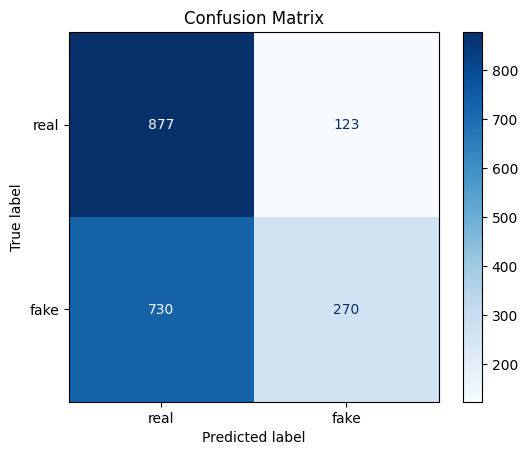

In [ ]:
image_root_path = os.getcwd()+"/dataset/FS/test"

# Create dataset and DataLoader
test_dataset = TestDataset(image_root_path, transform=transform)
dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count())

fake_idx = 0
real_idx = 1
pred_labels = []
correct_labels = []
correct = 0
# Iterate through the DataLoader with tqdm to display progress
for images, labels in tqdm(dataloader, total=len(dataloader), desc="Loading Data"):
    inputs = {
        ModalityType.TEXT: data.load_and_transform_text(text_list, device),
        ModalityType.VISION: images.to(device)
    }
    true_labels = labels
    with torch.no_grad():
        embeddings = model(inputs)

    # Assuming that embeddings[ModalityType.TEXT] contains the embedding vectors
    text_embeds = embeddings[ModalityType.TEXT]  # Assuming TEXT embeddings exist
    vision_embeds = embeddings[ModalityType.VISION]

    # Adjust according to whether 'lora' is enabled or not
    lora_factor = lora_factor if lora else 1

    # Softmax over dot product between vision and text embeddings
    similarities = torch.softmax(vision_embeds @ text_embeds.T * lora_factor, dim=-1)

    for i in range(len(true_labels)):
        im_emb = vision_embeds[i]
        true_label = true_labels[i]
        correct_labels.append(true_label)

        # Calculate similarity of current vision embedding with 'fake' and 'real' text embeddings
        sim_fake = similarities[i, fake_idx]  # Assuming `fake_idx` is index for 'fake' in TEXT embeddings
        sim_real = similarities[i, real_idx]  # Assuming `real_idx` is index for 'real' in TEXT embeddings

        # Classification based on the higher similarity score
        if sim_fake > sim_real:
            pred_label = "fake"
        else:
            pred_label = "real"

        pred_labels.append(pred_label)
        if pred_label == true_label:
            correct += 1

print("Accuracy: ", correct/len(pred_labels))
# Create confusion matrix
cm = confusion_matrix(correct_labels, pred_labels, labels=["real", "fake"])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["real", "fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# **NT**

Loading Data: 100%|██████████| 63/63 [02:14<00:00,  2.14s/it]


Accuracy:  0.546


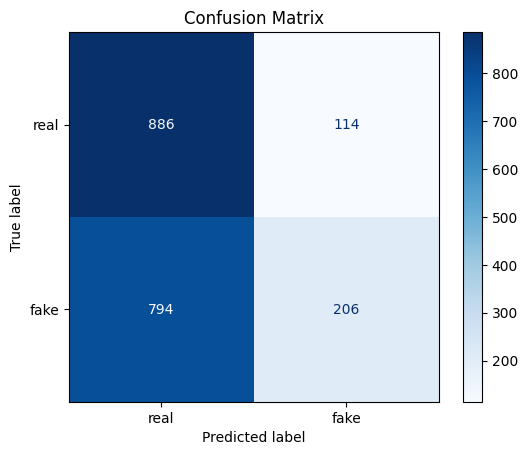

In [ ]:
image_root_path = os.getcwd()+"/dataset/NT/test"

# Create dataset and DataLoader
test_dataset = TestDataset(image_root_path, transform=transform)
dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count())

fake_idx = 0
real_idx = 1
pred_labels = []
correct_labels = []
correct = 0
# Iterate through the DataLoader with tqdm to display progress
for images, labels in tqdm(dataloader, total=len(dataloader), desc="Loading Data"):
    inputs = {
        ModalityType.TEXT: data.load_and_transform_text(text_list, device),
        ModalityType.VISION: images.to(device)
    }
    true_labels = labels
    with torch.no_grad():
        embeddings = model(inputs)

    # Assuming that embeddings[ModalityType.TEXT] contains the embedding vectors
    text_embeds = embeddings[ModalityType.TEXT]  # Assuming TEXT embeddings exist
    vision_embeds = embeddings[ModalityType.VISION]

    # Adjust according to whether 'lora' is enabled or not
    lora_factor = lora_factor if lora else 1

    # Softmax over dot product between vision and text embeddings
    similarities = torch.softmax(vision_embeds @ text_embeds.T * lora_factor, dim=-1)

    for i in range(len(true_labels)):
        im_emb = vision_embeds[i]
        true_label = true_labels[i]
        correct_labels.append(true_label)

        # Calculate similarity of current vision embedding with 'fake' and 'real' text embeddings
        sim_fake = similarities[i, fake_idx]  # Assuming `fake_idx` is index for 'fake' in TEXT embeddings
        sim_real = similarities[i, real_idx]  # Assuming `real_idx` is index for 'real' in TEXT embeddings

        # Classification based on the higher similarity score
        if sim_fake > sim_real:
            pred_label = "fake"
        else:
            pred_label = "real"

        pred_labels.append(pred_label)
        if pred_label == true_label:
            correct += 1

print("Accuracy: ", correct/len(pred_labels))
# Create confusion matrix
cm = confusion_matrix(correct_labels, pred_labels, labels=["real", "fake"])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["real", "fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# **DF**

Loading Data: 100%|██████████| 63/63 [02:18<00:00,  2.20s/it]


Accuracy:  0.6035


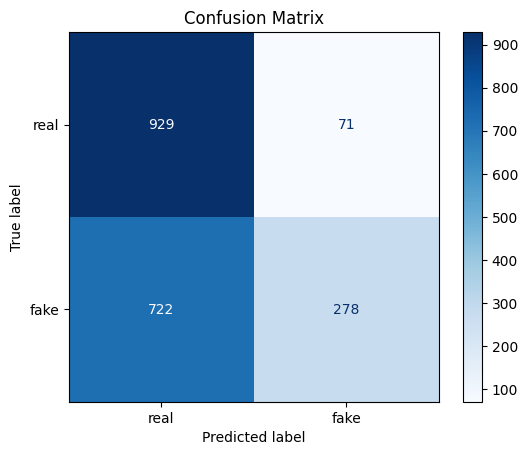

In [ ]:
image_root_path = os.getcwd()+"/dataset/DF/test"

# Create dataset and DataLoader
test_dataset = TestDataset(image_root_path, transform=transform)
dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count())

fake_idx = 0
real_idx = 1
pred_labels = []
correct_labels = []
correct = 0
# Iterate through the DataLoader with tqdm to display progress
for images, labels in tqdm(dataloader, total=len(dataloader), desc="Loading Data"):
    inputs = {
        ModalityType.TEXT: data.load_and_transform_text(text_list, device),
        ModalityType.VISION: images.to(device)
    }
    true_labels = labels
    with torch.no_grad():
        embeddings = model(inputs)

    # Assuming that embeddings[ModalityType.TEXT] contains the embedding vectors
    text_embeds = embeddings[ModalityType.TEXT]  # Assuming TEXT embeddings exist
    vision_embeds = embeddings[ModalityType.VISION]

    # Adjust according to whether 'lora' is enabled or not
    lora_factor = lora_factor if lora else 1

    # Softmax over dot product between vision and text embeddings
    similarities = torch.softmax(vision_embeds @ text_embeds.T * lora_factor, dim=-1)

    for i in range(len(true_labels)):
        im_emb = vision_embeds[i]
        true_label = true_labels[i]
        correct_labels.append(true_label)

        # Calculate similarity of current vision embedding with 'fake' and 'real' text embeddings
        sim_fake = similarities[i, fake_idx]  # Assuming `fake_idx` is index for 'fake' in TEXT embeddings
        sim_real = similarities[i, real_idx]  # Assuming `real_idx` is index for 'real' in TEXT embeddings

        # Classification based on the higher similarity score
        if sim_fake > sim_real:
            pred_label = "fake"
        else:
            pred_label = "real"

        pred_labels.append(pred_label)
        if pred_label == true_label:
            correct += 1

print("Accuracy: ", correct/len(pred_labels))
# Create confusion matrix
cm = confusion_matrix(correct_labels, pred_labels, labels=["real", "fake"])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["real", "fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# **DFD**

Loading Data: 100%|██████████| 63/63 [02:18<00:00,  2.20s/it]


Accuracy:  0.5555


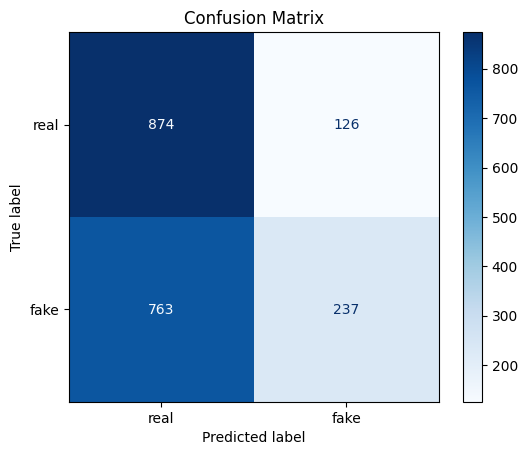

In [ ]:
image_root_path = os.getcwd()+"/dataset/DFD/test"

# Create dataset and DataLoader
test_dataset = TestDataset(image_root_path, transform=transform)
dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count())

fake_idx = 0
real_idx = 1
pred_labels = []
correct_labels = []
correct = 0
# Iterate through the DataLoader with tqdm to display progress
for images, labels in tqdm(dataloader, total=len(dataloader), desc="Loading Data"):
    inputs = {
        ModalityType.TEXT: data.load_and_transform_text(text_list, device),
        ModalityType.VISION: images.to(device)
    }
    true_labels = labels
    with torch.no_grad():
        embeddings = model(inputs)

    # Assuming that embeddings[ModalityType.TEXT] contains the embedding vectors
    text_embeds = embeddings[ModalityType.TEXT]  # Assuming TEXT embeddings exist
    vision_embeds = embeddings[ModalityType.VISION]

    # Adjust according to whether 'lora' is enabled or not
    lora_factor = lora_factor if lora else 1

    # Softmax over dot product between vision and text embeddings
    similarities = torch.softmax(vision_embeds @ text_embeds.T * lora_factor, dim=-1)

    for i in range(len(true_labels)):
        im_emb = vision_embeds[i]
        true_label = true_labels[i]
        correct_labels.append(true_label)

        # Calculate similarity of current vision embedding with 'fake' and 'real' text embeddings
        sim_fake = similarities[i, fake_idx]  # Assuming `fake_idx` is index for 'fake' in TEXT embeddings
        sim_real = similarities[i, real_idx]  # Assuming `real_idx` is index for 'real' in TEXT embeddings

        # Classification based on the higher similarity score
        if sim_fake > sim_real:
            pred_label = "fake"
        else:
            pred_label = "real"

        pred_labels.append(pred_label)
        if pred_label == true_label:
            correct += 1

print("Accuracy: ", correct/len(pred_labels))
# Create confusion matrix
cm = confusion_matrix(correct_labels, pred_labels, labels=["real", "fake"])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["real", "fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()